<h1> Predicting Single Family Home Prices </h1>
<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">

<h3> A. Business Deliverables and  Questions to Answer: </h3>
<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">
<br>
<h4> 1.  Construct an ML Regression model that predict property tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.</h4>
<br>
<h4>2. Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?</h4>
<br>
<h4> 3. Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.</h4>
<br>

<h3> B. DS pipeline and Linear Regression specific tasks: </h3>
<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">
<br>
    <b>a. Acquire/Wrangle Data</b>
<br>
        i. properties_2017, predictions_2017, propertylandusetype tables from SQL query in the zillow data set
<br>
        1. initially I imported 9 columns from those three tables through a SQL query in the initial Wrangle function.
        <br>
        ii. Remove nulls, outliers, and unneeded columns
    <br>
    iii. Run distributions to view data at 30k feet (get a sense for dataset)
    <br>
        iv. split data into train, validate, test
    <br>
    <b>b. Explore Data:</b>
        <br>
        i. hypothesize/pose questions, visually explore relationships with bivariate stats, produce subsets of interest, answer hypotheses visually, statistically, and in English
        <br>
        ii. produce synthetic columns if needed (BR/BD count, groupby's)
        <br>
   <b>c. Modeling:</b>
       <br>
       i. create a scaled copy of the data frame (don't scale target variable)
       <br>
       ii. produce at least 4 models (more if time allows), and add to the DataFrame, as well as prediction error for each model.
       <br>
           - a. error units will be RMSE (dollars)
       <br>
       iii. compare model's performance to the baseline, and the Zillow predicitive model performance.
    <br>
   <b>d. Report</b>
   <br>
       i. Produce a clean notebook and README, with HTML and visuals
       <br>
       ii. Docstrings on all functions
       <br>
       iii. make script/outline, time presentation
       <br>

<h2> 1. Acquisition/Preparation </h2>
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px">

- a. SQL query to acquire and prep tables from Zillow tables: properties_2017, predictions_2017, propertylandusetype tables
- b. target variable: taxvaluedollarcnt (price) for single family homes
- c. columns of interest:
    - properties_2017: calculatedfinishedsqft AS home_sq_ft, garagecarcnt, fips AS county, lotsizesquarefeet AS lot_size, roomcnt as room_count, taxvaluedollarcnt as tax_assessed_price, fips as county
    - predictions_2017: parcelid, logerror
    - propertylandusetables: id and desc as Single Family Home filters
- d. <b>notes on data wrangling:</b>
    - columns that were ultimately dropped for clarity: parcelid, logerror
    - I removed the column 'taxamount' (leaky column)
    - columns dropped for nulls: garage and room count
    - I removed outliers by a function that defined outliers as quantitative variables more than 3.5 standard deviations outside the norm. This did not affect more than 2% of the data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import env
import os
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import wrangle

In [3]:
df = wrangle.get_zillow_data()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedroomcnt          52442 non-null  float64
 1   bathroomcnt         52442 non-null  float64
 2   sq_ft               52360 non-null  float64
 3   lot_size            52073 non-null  float64
 4   room_count          52442 non-null  float64
 5   tax_assessed_price  52441 non-null  float64
 6   yearbuilt           52326 non-null  float64
 7   taxamount           52438 non-null  float64
 8   county              52442 non-null  float64
dtypes: float64(9)
memory usage: 3.6 MB


In [6]:
# make Parcelid, county into objects in the prep_zillow function

In [7]:
#run through the prep function to scrub nulls and whitespace cells
# 𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒)
df = wrangle.prep_zillow(df)
df.head()

(51765, 9)
(50565, 9)


,bedroomcnt,bathroomcnt,sq_ft,lot_size,room_count,tax_assessed_price,yearbuilt,taxamount,county
0,4.0,3.5,3100.0,4506.0,0.0,1023282.0,1998.0,11013.72,orange_county
1,2.0,1.0,1465.0,12647.0,5.0,464000.0,1967.0,5672.48,ventura
2,3.0,2.0,1243.0,8432.0,6.0,564778.0,1962.0,6488.30,orange_county
3,4.0,3.0,2376.0,13038.0,0.0,145143.0,1970.0,1777.51,los_angeles
4,4.0,3.0,2962.0,63000.0,0.0,773303.0,1950.0,9516.26,los_angeles


In [10]:
# room counts are empty in over 70% of rows, so I'll drop from DF
df = df.drop(columns=['room_count', 'taxamount'])

,bedroomcnt,bathroomcnt,sq_ft,lot_size,tax_assessed_price,yearbuilt,county
0,4.0,3.5,3100.0,4506.0,1023282.0,1998.0,orange_county
1,2.0,1.0,1465.0,12647.0,464000.0,1967.0,ventura
2,3.0,2.0,1243.0,8432.0,564778.0,1962.0,orange_county
3,4.0,3.0,2376.0,13038.0,145143.0,1970.0,los_angeles
4,4.0,3.0,2962.0,63000.0,773303.0,1950.0,los_angeles


<h2> 1.B. Distribution Visualization </h2>
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px">

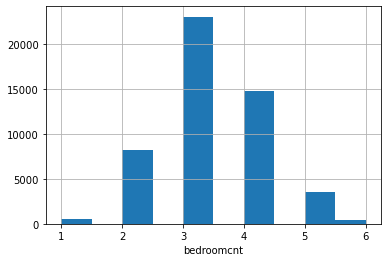

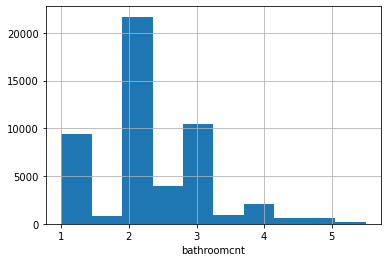

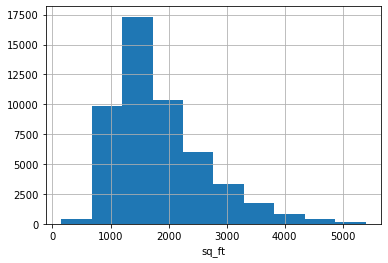

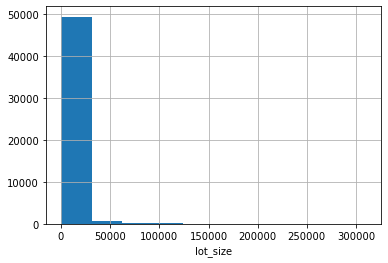

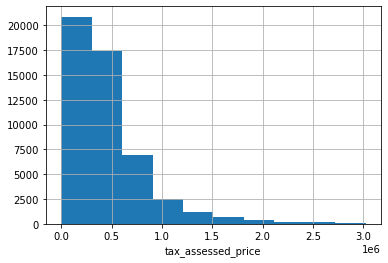

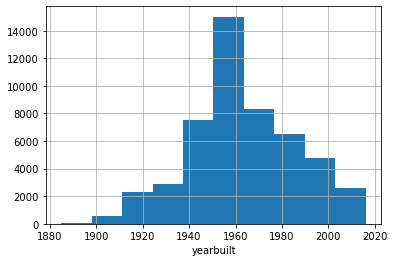

In [13]:
# Let's take a look at distributions of data for our dataset

non_quants = ['county']
quants = df.drop(columns=non_quants).columns

for col in quants:
    df[col].hist()
    plt.xlabel(col)
    plt.show()

In [12]:
df.county.value_counts()

los_angeles      32600
orange_county    13707
ventura           4258
Name: county, dtype: int64

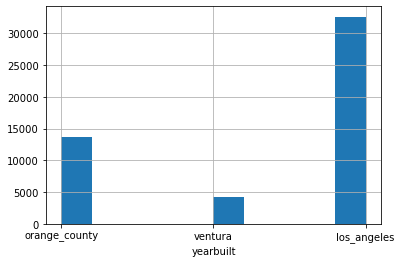

In [14]:
    df['county'].hist()
    plt.xlabel(col)
    plt.show()

### Univariate Stats Notes:
<div class="alert alert-block alert-warning"> 
- bedroom count is normally dist around a mean of 3
    <br>
- bathroom count is normally dist around a mean of 2
    <br>
- sqft is relatively normal, but right skewed, with mean of 1800
    <br>
- lot size has some huge outliers....let's plot this one later on
    <br>
- tax assessed price is heavily right skewed, with a mean of 462k
    <br>
- year built is normally distributed around 1960..plot year aginst price
    <br>
- 65/27/8% split for dist of homes in the sample betwween LA, OC and Ventura counties

<h2> 1.C. Split, then Explore </h2>
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px">

In [15]:
import split

In [16]:
train, validate, test = split.train_validate_test_split(df, df.tax_assessed_price)
train.shape

(28316, 7)

<h2> 2. Exploratory Data Analysis </h2>
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px">

## Big Assumptions I want to test/answer:
<br>
1. Newer homes are more desirable to consumers than older homes
<br>
2. Some locations/counties are more desirable than others to consumers
<br>
3. Locations (counties) with newer homes are more desirable to consumers
<br>
4. Locations (counties) with larger homes are more desirable to consumers
<br>

## Bivariate Statistical Analysis
<hr>

<div class="alert alert-block alert-success">
<b>Question 1</b>: Are home prices significantly different pre-/post- 1963?
    <br>
- this is the mean home construction date
    <br>
- sub question:
    <br>
    - if yes, is there a difference in the predictive power of year built in those two timeframes?
    <br>
    - and...is there a difference in its predictive power by county?

In [18]:
train_post_1963=train[train.yearbuilt > 1963]
train_pre_1963=train[train.yearbuilt <= 1963]

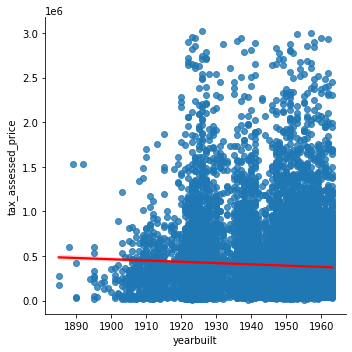

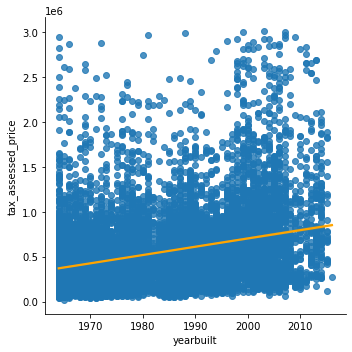

In [19]:
#plot1: PRE-1963 year vs price (cont:cont)
#plot2: POST-1963 year vs price (cont:cont)
sns.lmplot(x='yearbuilt', y='tax_assessed_price', data=train_pre_1963,
          line_kws = {'color': 'red'})
sns.lmplot(x='yearbuilt', y='tax_assessed_price', data=train_post_1963,
          line_kws = {'color': 'orange'})
plt.show()

<AxesSubplot:>

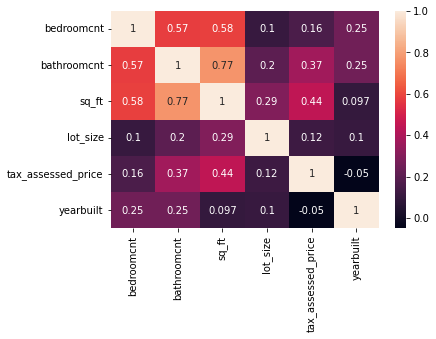

In [20]:
# Correlations pre-1963 for variables in Dataset:
sns.heatmap(train_pre_1963.corr(), annot=True)

<AxesSubplot:>

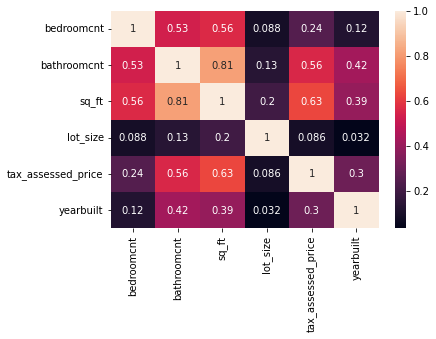

In [21]:
# Correlations pre-1963 for variables in Dataset:
sns.heatmap(train_post_1963.corr(), annot=True)

<div class="alert alert-block alert-warning"> 
<b>Takeaway 1A:</b>
    <br>
- interesting: the correlation between home price and  year built diverges before and after 1963: -0.05 vs. 0.29
    <br>
- let's test statistically for significance

### T-test the pre and post 1963 data for difference in means
1. The average construction year for homes is 1963. Is there a significant price difference between homes built before/after 1963?
<br>
    a. Null: no difference in mean home price for homes built before/after 1963.
    <br>
    b. Alt: there is a difference in mean home price between pre-1963 homes and post-1963 homes
    <br>
        i. use independent, two tailed t-test to check pop means for significant price difference
        <br>
    Note: the assumptions for the two tailed t-test is similar variance, and normal distribution. The sample is large enough that we can tolerate a non-normal distribution, but we need to check for variance.

In [22]:
# check for variance:
train_pre_1963.tax_assessed_price.var(), train_post_1963.tax_assessed_price.var()

(149019827235.68085, 177489303540.05322)

In [23]:
# the ratio of variance:
train_pre_1963.tax_assessed_price.var()/train_post_1963.tax_assessed_price.var()

0.8395989181514378

In [24]:
# The variance is close enough to proceed with the t-test

In [25]:
# Set the t- and p-values
t, p = stats.ttest_ind(train_pre_1963.tax_assessed_price, train_post_1963.tax_assessed_price) #array v scalar
t, p

(-32.08953810348872, 5.863572476846355e-222)

In [26]:
a = 0.05

In [27]:
if p < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home price for homes built before/after 1963")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home price for homes built before/after 1963")

We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home price for homes built before/after 1963


<div class="alert alert-block alert-warning">
    <b>Takeaway 1B:</b>
    <br>
- there is a significant difference in mean home price before and after 1963 (mean build year)
    <br>
- additionally, there is a difference in the predictive power of 'yearbuilt' pre- and post-1963. This is a much more effective predictor post-1963 (see graph below: -0.05 correl pre-1963, 0.29 post-1963)
    <br>
- given more time, I would use pre/post 1963 as a parameter for a split dataset with the predictor removed for pre-1963.

<div class="alert alert-block alert-success">
    <b>Question 2.</b> Does the county where a home is located have a significant impact on price? 
<br>
    a. Null: no difference in mean home price between counties.
    <br>
    b. Alt: there is a difference in mean home price between between counties.
    <br>
        i. use two sample, independent t-test to check county means for significant price difference
        <br>

In [29]:
train_la=train[train.county == "los_angeles"]
train_oc=train[train.county == "orange_county"]
train_ventura=train[train.county == "ventura"]

In [30]:
avg_la_home_price = train_la.tax_assessed_price.mean()
avg_oc_home_price = train_oc.tax_assessed_price.mean()
avg_ventura_home_price = train_ventura.tax_assessed_price.mean()
avg_la_home_price

423866.0951829806

In [31]:
print("The mean LA county home price is ", avg_la_home_price)
print("The mean OC home price is ", avg_oc_home_price)
print("The mean Ventura county home price is", avg_ventura_home_price)

The mean LA county home price is  423866.0951829806
The mean OC home price is  551684.5948065304
The mean Ventura county home price is 489874.1909736732


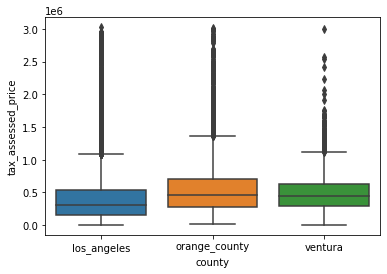

In [32]:
sns.boxplot(x='county', y='tax_assessed_price', data=train)
plt.show()

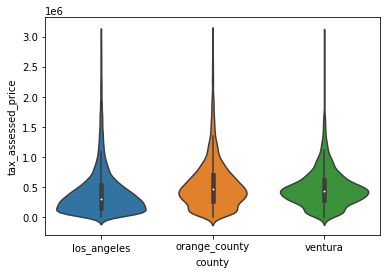

In [33]:
sns.violinplot(x='county', y='tax_assessed_price', data=train)
plt.show()

### Takeaway 2A:
- the mean prices across counties are clearly different, let's see if the differences are statistically significant

In [34]:
train.tax_assessed_price.mean()

464558.9007275039

### t-test the data for difference in means
1. The average price for homes is . Is there a significant price difference between homes built in Ventura, OC, and LA counties?
<br>
    a. Null: no difference in mean home price between counties.
    <br>
    b. Alt: there is a difference in mean home price between between counties.
    <br>
        i. use one way (one IV), three level ANOVA with replication (seperate groups being measured) to check counties for significant price difference
        <br>

In [35]:
# check for variance:
train_la.tax_assessed_price.var(), train_oc.tax_assessed_price.var(), train_ventura.tax_assessed_price.var()

(167278673112.0948, 177634866183.98315, 97944356775.92471)

In [36]:
# the ratio of variance:
train_oc.tax_assessed_price.var()/train_ventura.tax_assessed_price.var()

1.8136304329444208

In [37]:
# The variance needs to be adjusted in the t-test, equal_var=false

In [38]:
# Set the t- and p-values
# test LA vs OC
t1, p1 = stats.ttest_ind(train_la.tax_assessed_price, train_oc.tax_assessed_price, equal_var=False)
print(f"LA vs OC home price means testing: t-stat is {t1.round(5)}, p-stat is {p1.round(5)}")
print("______________________________________________________________________________________________")
# test LA vs Ventura
t2, p2 = stats.ttest_ind(train_la.tax_assessed_price, train_ventura.tax_assessed_price, equal_var=False)
print(f"LA vs Ventura home price means testing: t-stat is {t2.round(5)}, p-stat is {p2.round(5)}")
print("______________________________________________________________________________________________")
# test OC vs Ventura
t3, p3 = stats.ttest_ind(train_oc.tax_assessed_price, train_ventura.tax_assessed_price, equal_var=False)
print(f"OC vs Ventura home price means testing: t-stat is {t3.round(5)}, p-stat is {p3.round(5)}")
print("______________________________________________________________________________________________")

LA vs OC home price means testing: t-stat is -22.57605, p-stat is 0.0
______________________________________________________________________________________________
LA vs Ventura home price means testing: t-stat is -9.32107, p-stat is 0.0
______________________________________________________________________________________________
OC vs Ventura home price means testing: t-stat is 7.74054, p-stat is 0.0
______________________________________________________________________________________________


In [39]:
a = 0.05

In [40]:
if p1 < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home price between LA and OC counties")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home price between LA and OC counties")

if p2 < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home price between LA and Ventura counties")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home price between LA and Ventura counties")

if p3 < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home price between OC and Ventura counties")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home price between OC and Ventura counties")

We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home price between LA and OC counties
We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home price between LA and Ventura counties
We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home price between OC and Ventura counties


### Takeaway 2B:
- there is a significant difference in mean home price between counties.

<div class="alert alert-block alert-success">
    <b>Question 3. </b>Does the county where a home is located have a significant impact on total sqft? 
<br>
    a. Null: no difference in mean home sq_ft between counties.
    <br>
    b. Alt: there is a difference in mean home sq_ft between between counties.
    <br>
        i. use two sample, independent t-test to check county means for significant price difference
        <br>

In [41]:
train.head(1)

,bedroomcnt,bathroomcnt,sq_ft,lot_size,tax_assessed_price,yearbuilt,county
35203,3.0,2.0,1786.0,3252.0,169940.0,1994.0,los_angeles


In [42]:
train_la=train[train.county == "los_angeles"]
train_oc=train[train.county == "orange_county"]
train_ventura=train[train.county == "ventura"]

In [43]:
avg_la_sq_ft = train_la.sq_ft.mean()
avg_oc_sq_ft = train_oc.sq_ft.mean()
avg_ventura_sq_ft = train_ventura.sq_ft.mean()
avg_la_sq_ft

1723.1405974426807

In [44]:
print("The mean LA county home sq_ft is ", avg_la_sq_ft)
print("The mean OC home sq_ft is ", avg_oc_sq_ft)
print("The mean Ventura county sq_ft price is", avg_ventura_sq_ft)

The mean LA county home sq_ft is  1723.1405974426807
The mean OC home sq_ft is  2058.9569353387324
The mean Ventura county sq_ft price is 2058.111993313832


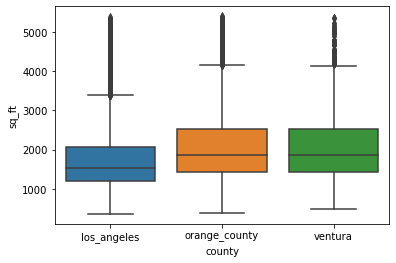

In [45]:
sns.boxplot(x='county', y='sq_ft', data=train)
plt.show()

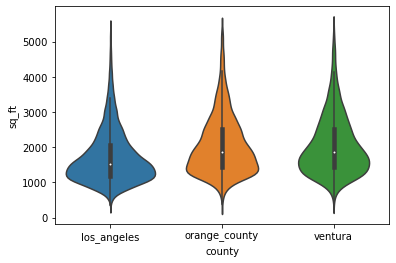

In [46]:
sns.violinplot(x='county', y='sq_ft', data=train)
plt.show()

### Takeaway 3A:
- the mean sq_ft across counties are different for LA: OC and LA: Ventura, let's see if the differences are statistically significant

In [47]:
train.sq_ft.mean()

1843.705007769459

### t-test the data for difference in means
1. The average price for homes is . Is there a significant price difference between homes built in Ventura, OC, and LA counties?
<br>
    a. Null: no difference in mean home price between counties.
    <br>
    b. Alt: there is a difference in mean home price between between counties.
    <br>
        i. use one way (one IV), three level ANOVA with replication (seperate groups being measured) to check counties for significant price difference
        <br>

In [48]:
# check for variance:
train_la.sq_ft.var(), train_oc.sq_ft.var(), train_ventura.sq_ft.var()

(567750.9792391526, 708941.3870626542, 697085.2466495776)

In [49]:
# the ratio of variance:
train_oc.sq_ft.var()/train_ventura.sq_ft.var()

1.0170081643099766

In [50]:
# The variance does not need to be adjusted in the t-test, equal_var=True

In [51]:
# Set the t- and p-values
# test LA vs OC
t1, p1 = stats.ttest_ind(train_la.sq_ft, train_oc.sq_ft)
print(f"LA vs OC home sq_ft means testing: t-stat is {t1.round(5)}, p-stat is {p1.round(5)}")
print("______________________________________________________________________________________________")
# test LA vs Ventura
t2, p2 = stats.ttest_ind(train_la.sq_ft, train_ventura.sq_ft)
print(f"LA vs Ventura home sq_ft means testing: t-stat is {t2.round(5)}, p-stat is {p2.round(5)}")
print("______________________________________________________________________________________________")
# test OC vs Ventura
t3, p3 = stats.ttest_ind(train_oc.sq_ft, train_ventura.sq_ft)
print(f"OC vs Ventura home sq_ft means testing: t-stat is {t3.round(5)}, p-stat is {p3.round(5)}")
print("______________________________________________________________________________________________")

LA vs OC home sq_ft means testing: t-stat is -31.72349, p-stat is 0.0
______________________________________________________________________________________________
LA vs Ventura home sq_ft means testing: t-stat is -20.17489, p-stat is 0.0
______________________________________________________________________________________________
OC vs Ventura home sq_ft means testing: t-stat is 0.04301, p-stat is 0.96569
______________________________________________________________________________________________


In [52]:
a = 0.05

In [53]:
if p1 < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home sq_ft between LA and OC counties")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home sq_ft between LA and OC counties")

if p2 < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home sq_ft between LA and Ventura counties")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home sq_ft between LA and Ventura counties")

if p3 < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home sq_ft between OC and Ventura counties")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home sq_ft between OC and Ventura counties")

We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home sq_ft between LA and OC counties
We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home sq_ft between LA and Ventura counties
We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home sq_ft between OC and Ventura counties


### Takeaway 3B:
- there is a significant difference in mean home sq_ft between counties, in the case of LA and OC, LA and Ventura, but not between Ventura and OC.

<div class="alert alert-block alert-success">
    <b>Question 4. </b>Is the average house newer in some counties than others?
<br>
    a. Null: no difference in mean home year built between counties.
    <br>
    b. Alt: there is a difference in mean home year built between counties.
    <br>
        i. use independent, two tailed t-test to check pop means for significant price difference
        <br>

In [54]:
train.head(1)

,bedroomcnt,bathroomcnt,sq_ft,lot_size,tax_assessed_price,yearbuilt,county
35203,3.0,2.0,1786.0,3252.0,169940.0,1994.0,los_angeles


In [55]:
train_la=train[train.county == "los_angeles"]
train_oc=train[train.county == "orange_county"]
train_ventura=train[train.county == "ventura"]

In [56]:
avg_la_yearbuilt = train_la.yearbuilt.mean()
avg_oc_yearbuilt = train_oc.yearbuilt.mean()
avg_ventura_yearbuilt = train_ventura.yearbuilt.mean()
train.yearbuilt.mean()

1963.0658285068512

In [57]:
print("The mean LA county home yearbuilt is ", avg_la_yearbuilt)
print("The mean OC home yearbuilt is ", avg_oc_yearbuilt)
print("The mean Ventura county yearbuilt is", avg_ventura_yearbuilt)

The mean LA county home yearbuilt is  1956.5890652557318
The mean OC home yearbuilt is  1974.0852294639415
The mean Ventura county yearbuilt is 1976.3522774759715


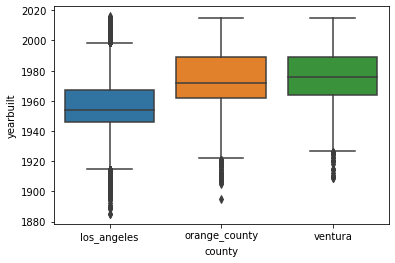

In [58]:
sns.boxplot(x='county', y='yearbuilt', data=train)
plt.show()

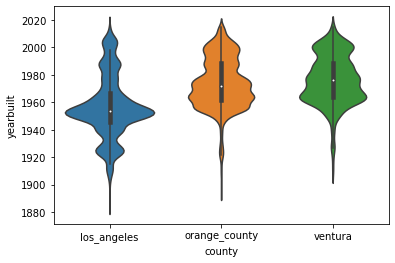

In [59]:
sns.violinplot(x='county', y='yearbuilt', data=train)
plt.show()

### Takeaway 4A:
- the mean yearbuilt across counties are different for LA: OC and LA: Ventura, but Ventura:OC is very similar. Let's see if the differences are statistically significant.

In [60]:
train.sq_ft.mean()

1843.705007769459

### t-test the data for difference in means
1. Is there a significant yearbuilt difference between homes built in Ventura, OC, and LA counties?
<br>
    a. Null: no difference in mean yearbuilt between counties.
    <br>
    b. Alt: there is a difference in mean yearbuilt between between counties.
    <br>
       i. use independent, two tailed t-test to check pop means for significant yearbuilt difference
        <br>

In [61]:
# check for variance:
train_la.yearbuilt.var(), train_oc.yearbuilt.var(), train_ventura.yearbuilt.var()

(503.27862374176044, 336.2178571439186, 327.39800588953)

In [62]:
# the ratio of variance:
train_la.yearbuilt.var()/train_oc.yearbuilt.var()

1.4968824916587675

In [63]:
# The variance does not need to be adjusted in the t-test, equal_var=True

In [64]:
# Set the t- and p-values
# test LA vs OC
t1, p1 = stats.ttest_ind(train_la.yearbuilt, train_oc.yearbuilt)
print(f"LA vs OC home yearbuilt means testing: t-stat is {t1.round(5)}, p-stat is {p1.round(5)}")
print("______________________________________________________________________________________________")
# test LA vs Ventura
t2, p2 = stats.ttest_ind(train_la.yearbuilt, train_ventura.yearbuilt)
print(f"LA vs Ventura home yearbuilt means testing: t-stat is {t2.round(5)}, p-stat is {p2.round(5)}")
print("______________________________________________________________________________________________")
# test OC vs Ventura
t3, p3 = stats.ttest_ind(train_oc.yearbuilt, train_ventura.yearbuilt)
print(f"OC vs Ventura home yearbuilt means testing: t-stat is {t3.round(5)}, p-stat is {p3.round(5)}")
print("______________________________________________________________________________________________")

LA vs OC home yearbuilt means testing: t-stat is -60.6468, p-stat is 0.0
______________________________________________________________________________________________
LA vs Ventura home yearbuilt means testing: t-stat is -41.35682, p-stat is 0.0
______________________________________________________________________________________________
OC vs Ventura home yearbuilt means testing: t-stat is -5.30548, p-stat is 0.0
______________________________________________________________________________________________


In [65]:
a = 0.05

In [66]:
if p1 < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home yearbuilt between LA and OC counties")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home yearbuilt between LA and OC counties")

if p2 < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home yearbuilt between LA and Ventura counties")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home yearbuilt between LA and Ventura counties")

if p3 < a:
    print("We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home yearbuilt between OC and Ventura counties")
else:
    print("We have sufficient evidence to ACCEPT the null hypothesis that there no difference in mean home yearbuilt between OC and Ventura counties")

We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home yearbuilt between LA and OC counties
We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home yearbuilt between LA and Ventura counties
We have sufficient evidence to REJECT the null hypothesis that there is no difference in mean home yearbuilt between OC and Ventura counties


### Takeaway 4B:
- there is a significant difference in mean home yearbuilt between all counties

<h2> Exploration Takeaways:</h2>
<hr style="border-top: 5px groove limegreen; margin-top: 1px; margin-bottom: 1px">
<br>
<div class="alert alert-block alert-warning">
<h3> Takeaway 1B:</h3>
- there is a significant difference in mean home price before and after 1963 (mean build year)
- additionally, there is a difference in the predictive power of 'yearbuilt' pre- and post-1963. This is a much more effective predictor post-1963 (see graph below: -0.05 correl pre-1963, 0.29 post-1963)
- given more time, I would use pre/post 1963 as a parameter for a split dataset with the predictor removed for pre-1963.
<br>
<h3>Takeaway 2B:</h3>
- there is a significant difference in mean home price between counties.
<br>
<h3>Takeaway 3B:</h3>
- there is a significant difference in mean home sq_ft between counties, in the case of LA and OC, LA and Ventura, but not between Ventura and OC.
<br>
<h3>Takeaway 4B:</h3>
- there is a significant difference in mean home yearbuilt between all counties
<br>

<h2> 4. Modeling </h2>
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px">

In [67]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt
import sklearn.preprocessing

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

In [68]:
train.head(1)

,bedroomcnt,bathroomcnt,sq_ft,lot_size,tax_assessed_price,yearbuilt,county
35203,3.0,2.0,1786.0,3252.0,169940.0,1994.0,los_angeles


<h3> Scale </h3>

In [69]:
# Use MinMaxScaler
scaler = sklearn.preprocessing.MinMaxScaler()

In [101]:
#encode the categorical variable: county (originally called FIPS)
encoded_train = wrangle.encode_zillow(train)
encoded_validate = wrangle.encode_zillow(validate)
encoded_test = wrangle.encode_zillow(test)

In [73]:
encoded_train.head()

,bedroomcnt,bathroomcnt,sq_ft,lot_size,tax_assessed_price,yearbuilt,county_orange_county,county_ventura
35203,3.0,2.0,1786.0,3252.0,169940.0,1994.0,0,0
7809,3.0,2.5,1668.0,6630.0,323045.0,1987.0,1,0
28730,3.0,2.0,1784.0,7107.0,156342.0,1955.0,0,0
18822,4.0,2.0,1836.0,4666.0,297413.0,1967.0,0,0
8823,2.0,2.0,1650.0,7547.0,147620.0,1940.0,0,0


In [74]:
#Split into X and y sets

In [75]:
X_train = encoded_train.drop(columns='tax_assessed_price')
y_train = encoded_train.drop(columns=X_train)

X_validate = encoded_validate.drop(columns='tax_assessed_price')
y_validate = encoded_validate.drop(columns=X_validate)

X_test = encoded_test.drop(columns='tax_assessed_price')
y_test = encoded_test.drop(columns=X_test)

In [77]:
#scale the x sets

In [78]:
X_scaled_train, X_scaled_validate, X_scaled_test = wrangle.fit_and_scale(scaler, X_train, X_validate, X_test)
X_scaled_train.head(1)


,bedroomcnt,bathroomcnt,sq_ft,lot_size,yearbuilt
0,0.4,0.222222,0.283161,0.008827,0.832061


<h3> Calculate Baseline Error </h3>

In [79]:
# the baseline prediction is equal to the mean home price for all homes

In [80]:
# add baseline for y_train
y_train['baseline_pred_price'] = y_train.tax_assessed_price.mean()
y_validate['baseline_pred_price'] = y_validate.tax_assessed_price.mean()
#compute residual error for the baseline prediction:
y_train['baseline_residual'] = y_train.tax_assessed_price - y_train.baseline_pred_price


In [ ]:
# compute baseline RMSE
baseline_RMSE = mean_squared_error(y_train.tax_assessed_price, y_train.baseline_pred_price)**(1/2)

In [102]:
print("The baseline RMSE is:", baseline_RMSE)

The baseline RMSE is: 409205.5775699491


## Model 1: Linear Regression (OLS)

In [83]:
# Linear Regression (OLS)
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_scaled_train, y_train.tax_assessed_price)

# predict price on train dataset
y_train['train_OLS_pred_price'] = lm.predict(X_scaled_train)

# evaluate: rmse
ols_rmse_train = mean_squared_error(y_train.tax_assessed_price, y_train.train_OLS_pred_price)**(1/2)

# predict validate
y_validate['validate_OLS_pred_price'] = lm.predict(X_scaled_validate)

# evaluate: rmse
ols_rmse_validate = mean_squared_error(y_validate.tax_assessed_price, y_validate.validate_OLS_pred_price)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", ols_rmse_train, 
      "\nValidation/Out-of-Sample: ", ols_rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  332350.6925044572 
Validation/Out-of-Sample:  320430.69224367815


## Model 2: LassoLars

In [86]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_scaled_train, y_train.tax_assessed_price)

# predict train
y_train['train_lars_pred_price'] = lars.predict(X_scaled_train)

# evaluate: rmse
lars_rmse_train = mean_squared_error(y_train.tax_assessed_price, y_train.train_lars_pred_price)**(1/2)

# predict validate
y_validate['validate_lars_pred_price'] = lars.predict(X_scaled_validate)

# evaluate: rmse
lars_rmse_validate = mean_squared_error(y_validate.tax_assessed_price, y_validate.validate_lars_pred_price)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", lars_rmse_train, 
      "\nValidation/Out-of-Sample: ", lars_rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  332351.17140062834 
Validation/Out-of-Sample:  320432.4628055272


## Model 3: Tweedie Regressor (GLM)
- note: home prices are not normally distributed, instead they form an inverse gaussian distribution (peaking near y-axis, with a long rightward tail (right skewed)). Refer to Histogram below for detail. Therefore the power parameter in the GLM will be set to 3.

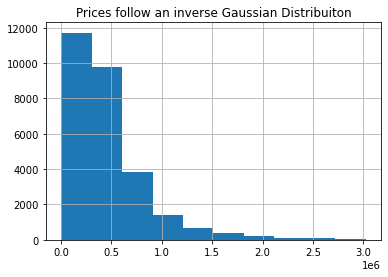

In [90]:
train.tax_assessed_price.hist()
plt.title("Prices follow an inverse Gaussian Distribuiton")
plt.show()

In [91]:
    # create the model object
    glm = TweedieRegressor(power=3, alpha=0)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    glm.fit(X_scaled_train, y_train.tax_assessed_price)

    # predict train
    y_train['train_tweedie_pred_price'] = lars.predict(X_scaled_train)

    # evaluate: rmse
    tweedie_rmse_train = mean_squared_error(y_train.tax_assessed_price, y_train.train_tweedie_pred_price)**(1/2)

    # predict validate
    y_validate['validate_tweedie_pred_price'] = lars.predict(X_scaled_validate)

    # evaluate: rmse
    tweedie_rmse_validate = mean_squared_error(y_validate.tax_assessed_price, y_validate.validate_tweedie_pred_price)**(1/2)

    print("RMSE for GLM using Tweedie\nTraining/In-Sample: ", tweedie_rmse_train, 
          "\nValidation/Out-of-Sample: ", tweedie_rmse_validate)


RMSE for GLM using Tweedie
Training/In-Sample:  332351.17140062834 
Validation/Out-of-Sample:  320432.4628055272


## Model 4: Polynomial Regression

In [94]:
# based on the scatter plot distributions, I believe that degree=2 is appropriate
# for the polynomial regression model
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_scaled_train_degree2 = pf.fit_transform(X_scaled_train)

# transform X_validate_scaled & X_test_scaled
X_scaled_validate_degree2 = pf.transform(X_scaled_validate)
X_scaled_test_degree2 = pf.transform(X_scaled_test)

In [95]:
# Linear Regression (OLS)
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_scaled_train_degree2, y_train.tax_assessed_price)

# predict price on train dataset
y_train['train_poly_pred_price'] = lm2.predict(X_scaled_train_degree2)

# evaluate: rmse
poly_rmse_train = mean_squared_error(y_train.tax_assessed_price, y_train.train_poly_pred_price)**(1/2)

# predict validate
y_validate['validate_poly_pred_price'] = lm2.predict(X_scaled_validate_degree2)

# evaluate: rmse
poly_rmse_validate = mean_squared_error(y_validate.tax_assessed_price, y_validate.validate_poly_pred_price)**(1/2)

print("RMSE for Polynomial Regression using LinearRegression\nTraining/In-Sample: ", poly_rmse_train, 
      "\nValidation/Out-of-Sample: ", poly_rmse_validate)

RMSE for Polynomial Regression using LinearRegression
Training/In-Sample:  329472.116211125 
Validation/Out-of-Sample:  316753.2976007597


## Evaluate Model Performance

In [97]:
df_predictions = pd.DataFrame(columns=['model','RMSE','error_under_baseline', 'train_val_diff_percent', '%_better_than_baseline'])

In [103]:
df_predictions.model=['baseline','OLS', 'Lars', 'Tweedie', 'Poly']
df_predictions.RMSE=[ baseline_RMSE, ols_rmse_validate, lars_rmse_validate, tweedie_rmse_validate, poly_rmse_validate]
df_predictions.error_under_baseline=[(baseline_RMSE - baseline_RMSE),(ols_rmse_validate - baseline_RMSE),(lars_rmse_validate-baseline_RMSE) , (tweedie_rmse_validate - baseline_RMSE), (poly_rmse_validate - baseline_RMSE)]
df_predictions.train_val_diff_percent=[(baseline_RMSE - baseline_RMSE)/baseline_RMSE*100,(ols_rmse_validate - ols_rmse_train)/ols_rmse_validate*100,(lars_rmse_validate-lars_rmse_train)/lars_rmse_validate*100, (tweedie_rmse_validate - tweedie_rmse_train)/tweedie_rmse_validate*100, (poly_rmse_validate - poly_rmse_train)/poly_rmse_validate*100]
df_predictions['%_better_than_baseline']=[((baseline_RMSE - baseline_RMSE)/baseline_RMSE)*100,((baseline_RMSE - ols_rmse_validate)/ols_rmse_validate)*100,((baseline_RMSE - lars_rmse_validate)/lars_rmse_validate)*100 , ((baseline_RMSE - tweedie_rmse_validate)/tweedie_rmse_validate)*100, ((baseline_RMSE - poly_rmse_validate)/poly_rmse_validate)*100]
df_predictions.round(2)
df_predictions

,model,RMSE,error_under_baseline,train_val_diff_percent,%_better_than_baseline
0,baseline,409205.577570,0.000000,0.000000,0.000000
1,OLS,320430.692244,-88774.885326,-3.719993,27.704863
2,Lars,320432.462806,-88773.114764,-3.719570,27.704158
3,Tweedie,320432.462806,-88773.114764,-3.719570,27.704158
4,Poly,316753.297601,-92452.279969,-4.015371,29.187472


<div class="alert alert-block alert-warning"> 
    <b>Takeaways:</b>
    <br>
- Polynomial regression produces predictions with the least error, and best performance relative to the baseline, so I'm going to run this model on my test data.

In [99]:
# Linear Regression (OLS)
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_scaled_train_degree2, y_train.tax_assessed_price)

# predict test
test_poly_pred_price = lm2.predict(X_scaled_test_degree2)

# evaluate: rmse
poly_rmse_test = mean_squared_error(y_test.tax_assessed_price, test_poly_pred_price)**(1/2)

print("RMSE for Polynomial Regression using LinearRegression\nTraining/In-Sample: ", poly_rmse_train,
      "\nValidate/Out-of-Sample: ", poly_rmse_validate,
      "\nTest/Out-of-Sample: ", poly_rmse_test)

RMSE for Polynomial Regression using LinearRegression
Training/In-Sample:  329472.116211125 
Validate/Out-of-Sample:  316753.2976007597 
Test/Out-of-Sample:  318220.0736654698


## Model Performance Visualization

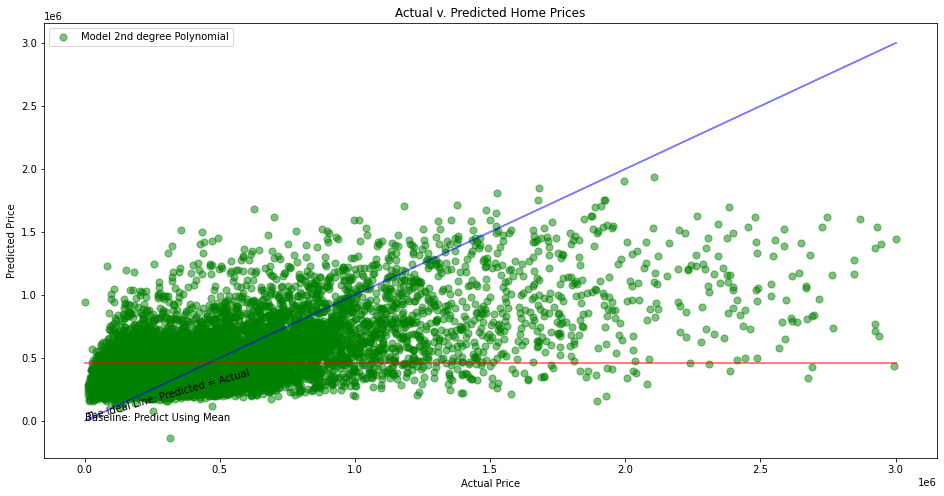

In [100]:
#plot the model's predicitions on a scatter plot, vs two lines representing
# baseline prediction and perfect predictive line.
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_assessed_price, y_validate.baseline_pred_price, alpha=.5, color="red", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_assessed_price, y_validate.tax_assessed_price, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_assessed_price, y_validate.validate_poly_pred_price, 
            alpha=.5, color="green", s=50, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual v. Predicted Home Prices")
plt.show()
# green dots closer to the blue line represent higher model accuracy.

<h2> Answers to Business Deliverables: </h3>
<hr style="border-top: 10px groove blue; margin-top: 1px; margin-bottom: 1px">
<br>
<h4> 1.  Construct an ML Regression model that predict property tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.</h4>
<br>
- The Polynomial Regression was the most positive improvement vs. the initial baseline prediction.
<br>
<h4>2. Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?</h4>
<br>
- Key variables that had a high correlation with home price include bathroom count, sq ft, and year built although these metrics vary in effectiveness by county, and pre- and post- 1963 yearbuilt.
<br>
<h4> 3. Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.</h4>
<br>
- Key findings and recommendations are included below
<br>

<h2> Key Findings </h2>
<hr style="border-top: 5px groove limegreen; margin-top: 1px; margin-bottom: 1px">
<br>
1. Three out of four models produced almost identical predictive accuracy (measured by RMSE). That takeaway leads me to conclude that feature selection is significantly more important than selecting model type, in linear regression models.
    <br>
    <br>
2. Model Accuracy: The Polynomial Regression Model provided a reduced error of <b>28%</b>, or <b>90k dollars</b>on the out-of-sample (test) data over the baseline prediction. This is meaningdful given the median home price in the dataset is <b>462k dollars</b>
<br>
<br>
3. Given additional time for fine tuning, I would:
<br>
- split the data by county
<br>
- split again by pre- and post- 1963
<br>
- run recursive feature selection on the split datasets to select the most impactful variables, I think these would be different for different counties and time periods
<br>
- incorporate lat/long locational data in a meaningful way. I think this will be a powerful predictor if it's properly leveraged.